In [27]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from copy import deepcopy
from datetime import datetime
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
import plotly.graph_objs as go
from sklearn.preprocessing import StandardScaler


In [3]:
data = pd.read_csv('../clean_data/velo_df.csv')


/var/folders/jg/x3y4bp6n6071zs7rycbnfsyc0000gn/T/ipykernel_58271/379476706.py:1: DtypeWarning:

Columns (30,32,33,34) have mixed types. Specify dtype option on import or set low_memory=False.



In [17]:
data.columns


Index(['Num_Acc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'aug', 'grav', 'sexe',
       'trajet', 'secu', 'locp', 'actp', 'etatp', 'an_nais', 'dup_count',
       'catr', 'circ', 'nbv', 'vosp', 'prof', 'plan', 'surf', 'infra', 'situ',
       'lum', 'agg', 'int', 'atm', 'col', 'com', 'adr', 'lat', 'long', 'dep',
       'date'],
      dtype='object')

<AxesSubplot:>

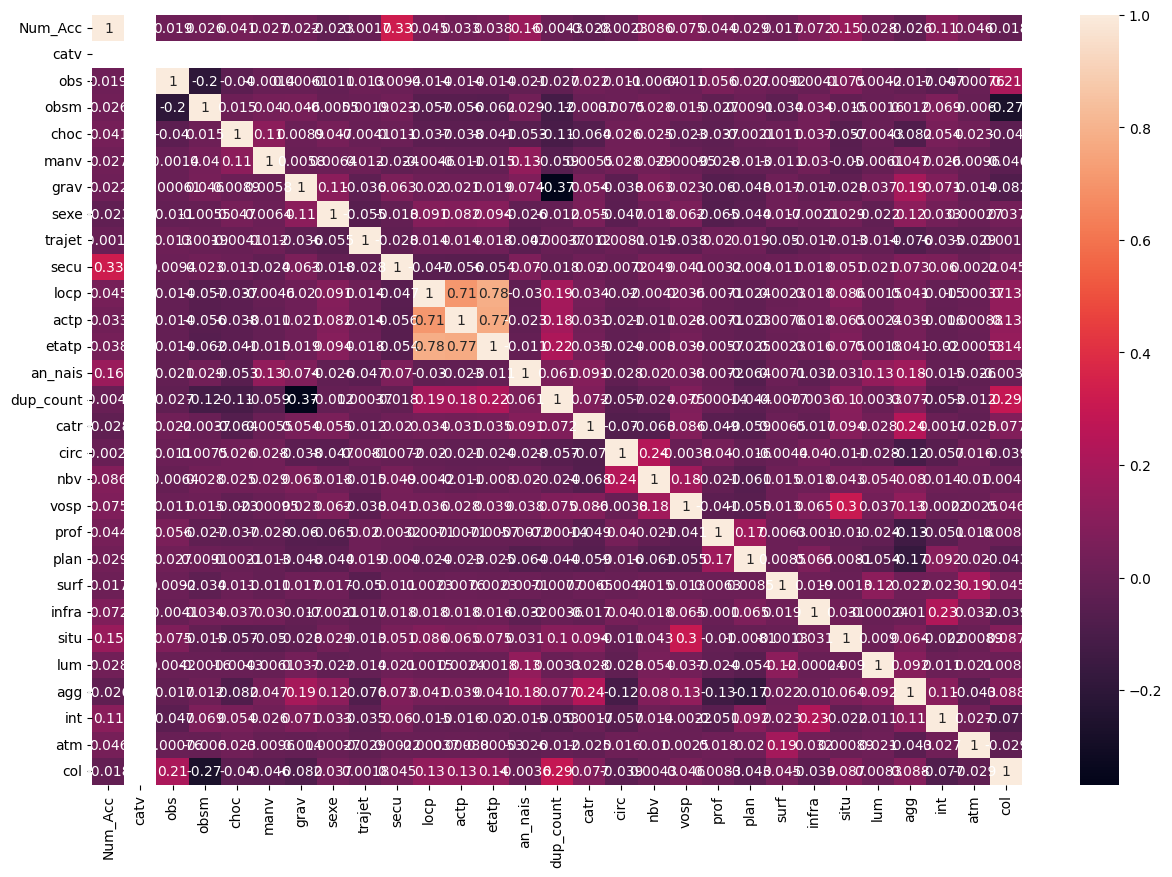

In [7]:
fig= plt.figure(figsize=(15,10))
ax1=plt.subplot()
sns.heatmap(data.corr(), annot=True)


### Accidents et lumière

lum
1.0    67853
2.0     4085
3.0     1715
4.0      339
5.0     9241
Name: Num_Acc, dtype: int64


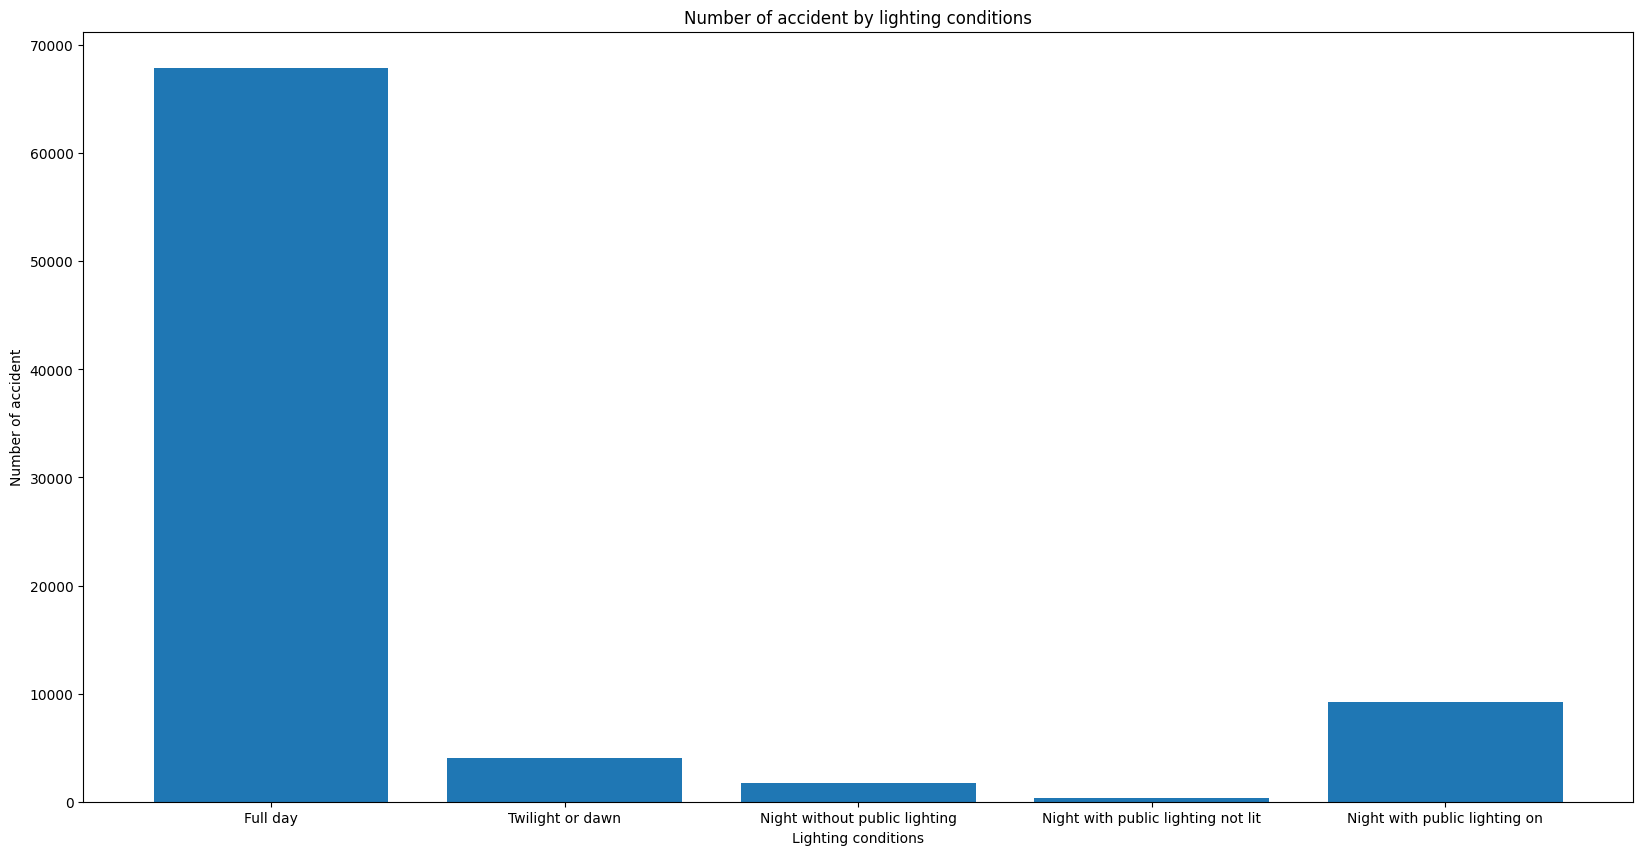

In [9]:
plt.figure(figsize=(20,10))
graph = data.groupby('lum')['Num_Acc'].count()
print(graph)
labels = ['Full day', 'Twilight or dawn', 'Night without public lighting', 'Night with public lighting not lit', 'Night with public lighting on']
plt.xticks(range(len(graph)), labels)
plt.xlabel('Lighting conditions')
plt.ylabel('Number of accident')
plt.bar(range(len(graph)), graph)
plt.title("Number of accident by lighting conditions")
plt.show()


### Accidents et type de routes

In [19]:
data.catr.value_counts()


4.0    54671
3.0    23022
2.0     2470
9.0     2027
7.0      440
6.0      341
5.0      176
1.0       86
Name: catr, dtype: int64

catr
1.0       86
2.0     2470
3.0    23022
4.0    54671
5.0      176
6.0      341
7.0      440
9.0     2027
Name: Num_Acc, dtype: int64


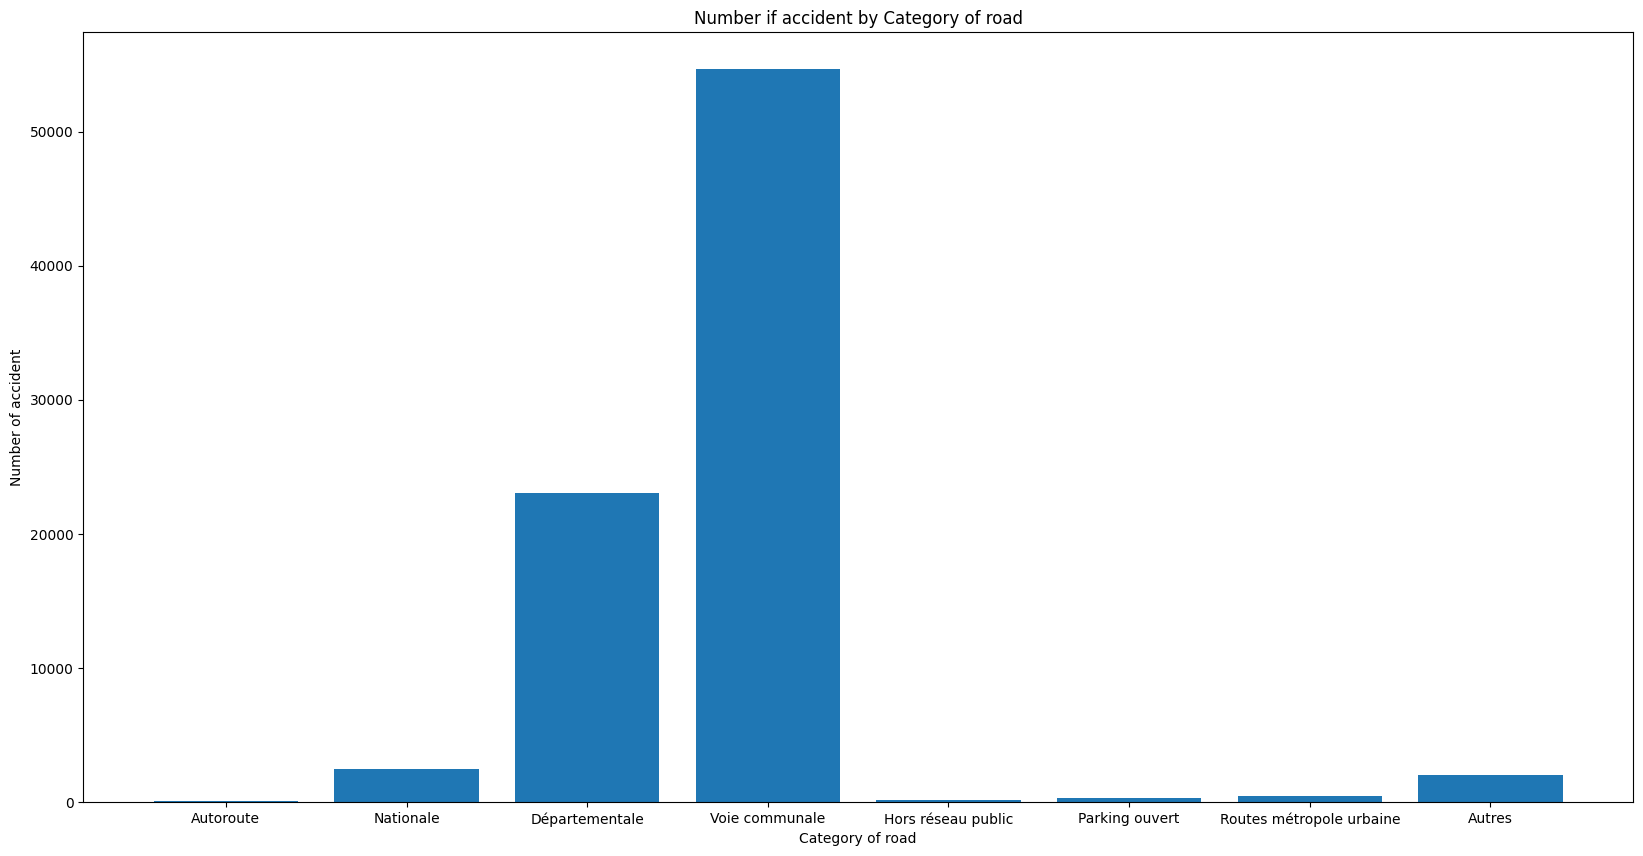

In [20]:
plt.figure(figsize=(20,10))
graph = data.groupby('catr')['Num_Acc'].count()
print(graph)
labels = ['Autoroute','Nationale', 'Départementale', 'Voie communale', 'Hors réseau public', 'Parking ouvert', 'Routes métropole urbaine', 'Autres']
plt.xticks(range(len(graph)), labels)
plt.xlabel('Category of road')
plt.ylabel('Number of accident')
plt.bar(range(len(graph)), graph)
plt.title("Number if accident by Category of road")
plt.show()


### Accidents par an

In [25]:
data['hour'] = pd.to_datetime(data['date']).dt.hour

# Fonction pour catégoriser les heures
def categorize_hour(hour):
    if 6 <= hour < 12:
        return 'Morning'
    elif 12 <= hour < 18:
        return 'Afternoon'
    elif 18 <= hour < 24:
        return 'Evening'
    else:
        return 'Night'

# Application de la catégorisation
data['time_category'] = data['hour'].apply(categorize_hour)


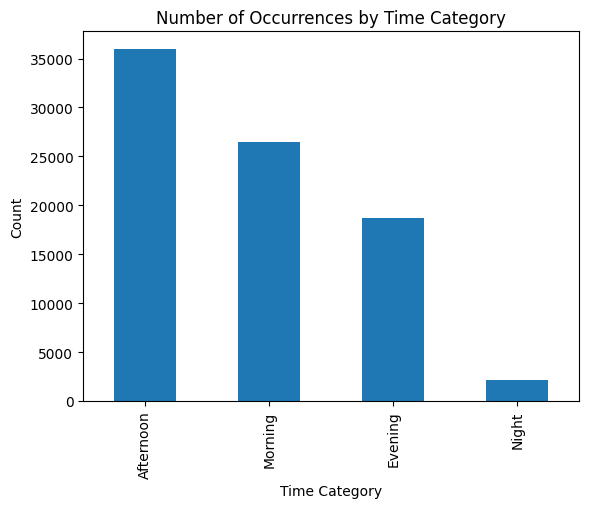

In [26]:
data['time_category'].value_counts().plot(kind='bar')
plt.xlabel('Time Category')
plt.ylabel('Count')
plt.title('Number of Occurrences by Time Category')
plt.show()


### Data


In [39]:
X = data[['lum','atm','catr']]
y = data['grav']


In [40]:
X.info


<bound method DataFrame.info of        lum  atm  catr
0      1.0  7.0   3.0
1      1.0  1.0   4.0
2      1.0  7.0   3.0
3      1.0  2.0   3.0
4      1.0  1.0   3.0
...    ...  ...   ...
83228  1.0  1.0   4.0
83229  1.0  1.0   2.0
83230  1.0  1.0   4.0
83231  1.0  1.0   4.0
83232  3.0  1.0   2.0

[83233 rows x 3 columns]>

### Standardization

In [41]:
from sklearn.preprocessing import StandardScaler
Scaler = StandardScaler()
X_scaler=Scaler.fit_transform(X)


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scaler, y, test_size=0.30, random_state=42)


In [43]:
import time
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression


### Random Forest

In [44]:
t0=time.time()
model_rf= RandomForestClassifier()
model_rf.fit(X_train, y_train)
print('Time taken :' , time.time()-t0)
y_pred_rf = model_rf.predict(X_test)
score_rf = accuracy_score(y_test,y_pred_rf)
print('Accuracy :',score_rf)


Time taken : 1.0154659748077393
Accuracy : 0.62563075690829


### KNN

In [45]:
t0=time.time()
model_knn= KNeighborsClassifier()
model_knn.fit(X_train, y_train)
print('Time taken :' , time.time()-t0)
y_pred_knn = model_knn.predict(X_test)
score_knn = accuracy_score(y_test,y_pred_knn)
print('Accuracy :',score_knn)


Time taken : 0.03464007377624512
Accuracy : 0.5731678013616339


### Logistic Regression

In [46]:
t0=time.time()
model_lr = LogisticRegression()
model_lr.fit(X_train, y_train)
print('Time taken :' , time.time()-t0)
y_pred_lr = model_lr.predict(X_test)
score_lr = accuracy_score(y_test,y_pred_lr)
print('Accuracy :',score_lr)


Time taken : 0.1829240322113037
Accuracy : 0.5914697637164598


### Evaluation

In [54]:
from sklearn.metrics import confusion_matrix


In [50]:
params_rf = {'n_estimators' : [100, 200], 'max_features': ['auto', 'sqrt', 'log2'],'max_depth' : [4,5,6,7,8]}
params_knn= {'n_neighbors' : [1, 5, 11, 19], 'weights' : ['uniform', 'distance'], 'metric' : ['euclidean', 'manhattan']}
params_lr={ 'penalty' : ['l1', 'l2'], 'class_weight' : ['dict', 'balanced']}


In [59]:
def evaluate_model(model, param, x_train, y_train, X_test, y_test):
    gs = GridSearchCV(estimator=model, param_grid=param, cv=5)
    gs.fit(x_train, y_train)
    y_pred = gs.predict(X_test)
    score = accuracy_score(y_test, y_pred)

    # Calcul de la matrice de confusion
    cm = confusion_matrix(y_test, y_pred)

    # Tracer la matrice de confusion avec seaborn et matplotlib
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=model.classes_, yticklabels=model.classes_)
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.title('Confusion Matrix')

    # Affichage de la matrice
    plt.show()

    # Retourner les meilleurs paramètres et le score
    return gs.best_params_, score, cm


#### Random Forest

/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning:


50 fits failed out of a total of 150.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/aurelienbrame/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Users/aurelienbrame/.pyenv/versions/3.10.6/env

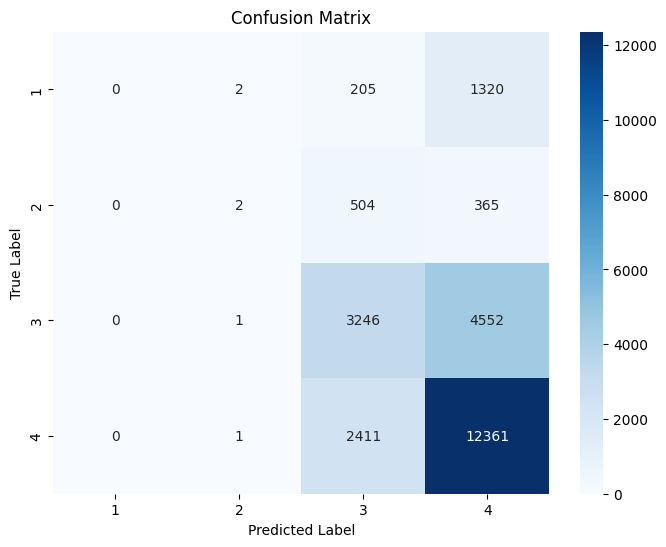

In [60]:
best_param_rf, score_rf, cm = evaluate_model(model_rf, params_rf,X_train,y_train, X_test, y_test)


In [61]:
best_param_rf


{'max_depth': 6, 'max_features': 'log2', 'n_estimators': 100}

In [62]:
score_rf


0.6251101321585903

#### KNN

In [ ]:
best_param_knn, score_knn, Mat = evaluate_model(model_knn, params_knn,X_train,y_train, X_test, y_test)


In [ ]:
best_param_knn


In [ ]:
score_knn


#### Log Reg

In [ ]:
best_param_lr, score_lr, Mat = evaluate_model(model_lr, params_lr,X_train,y_train, X_test, y_test)


In [ ]:
best_param_lr


In [ ]:
score_lr
